In [6]:
import torch
import gc
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch.nn.functional as F

# --- MEMORY MANAGEMENT ---
def clear_gpu():
    """Aggressively clears GPU memory."""
    if 'model' in globals():
        del globals()['model']
    if 'tokenizer' in globals():
        del globals()['tokenizer']
    gc.collect()
    torch.cuda.empty_cache()
    print("GPU cache cleared.")

# Check if model is already loaded to avoid OOM on re-runs
if 'model' not in globals() or 'tokenizer' not in globals():
    print("Loading model... (This only happens once)")
    model_id = "meta-llama/Llama-3.1-8B"
    
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(
        model_id, 
        torch_dtype=torch.float16, 
        device_map="auto"
    )
    model.eval()
else:
    print("Model already loaded. Skipping initialization.")

# --- INFERENCE ---
# 1. The "loaded" prompt (English Coins)
prompt_coins = (
    "Two coins. Type A is fair (50% heads). Type B is biased (75% heads). "
    "Sequence: H H T H H. "
    "Predict the next toss (H or T):"
)

# 2. The "neutral" prompt (Abstract Symbols)
# We use 'X' and 'Y' to avoid strong semantic associations
prompt_abstract = (
    "Two random generators. Generator A: 50% X. Generator B: 75% X. "
    "Sequence: X X Y X X. "
    "Predict the next output (X or Y):"
)

def get_prob(prompt, token_a, token_b):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        logits = model(**inputs).logits[0, -1, :].cpu()
    probs = F.softmax(logits, dim=-1)
    
    # Sum over common token variants (with/without spaces)
    id_a = tokenizer.encode(" " + token_a, add_special_tokens=False)[0]
    id_b = tokenizer.encode(" " + token_b, add_special_tokens=False)[0]
    
    pa = probs[id_a].item()
    pb = probs[id_b].item()
    
    return pa / (pa + pb) if (pa + pb) > 0 else 0

p_heads = get_prob(prompt_coins, "H", "T")
p_x = get_prob(prompt_abstract, "X", "Y")

print(f"Coin Context (Heads): {p_heads*100:.2f}%")
print(f"Abstract Context (X):   {p_x*100:.2f}%")

Model already loaded. Skipping initialization.
Coin Context (Heads): 83.01%
Abstract Context (X):   69.09%


Model already loaded. Ready for sweep.
Starting Calibration Sweep (Sequence Length = 10)...
------------------------------------------------------------

--- CALIBRATION TABLE ---
 n_X  True_Bayes  Model_Pred   Error  Abs_Error
   0      0.5002      0.3930 -0.1073     0.1073
   1      0.5007      0.3489 -0.1519     0.1519
   2      0.5022      0.4402 -0.0620     0.0620
   3      0.5064      0.5335  0.0271     0.0271
   4      0.5183      0.5817  0.0633     0.0633
   5      0.5479      0.6190  0.0711     0.0711
   6      0.6040      0.6356  0.0316     0.0316
   7      0.6703      0.6777  0.0075     0.0075
   8      0.7162      0.7361  0.0199     0.0199
   9      0.7376      0.7174 -0.0202     0.0202
  10      0.7457      0.8130  0.0673     0.0673

--- FINAL STATISTICS ---
Mean Absolute Error (MAE):  0.0572  (Lower is better)
Correlation (Pearson R):    0.8903  (Higher is better)
Mean Bias (Avg Error):      -0.0049  (Positive = Overpredicts X)


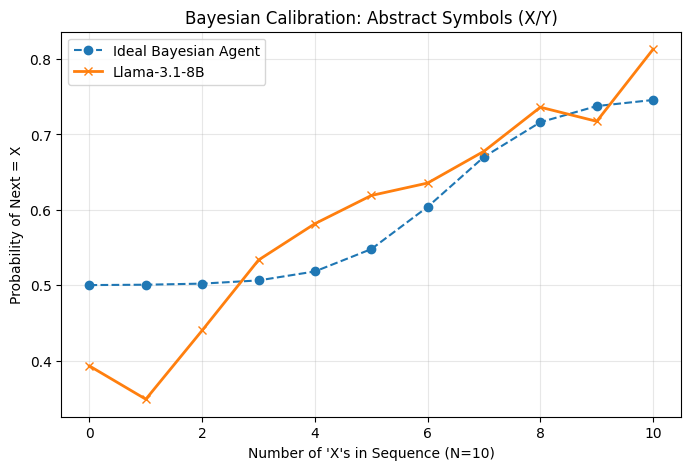

In [7]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch.nn.functional as F

# --- 1. SETUP & MODEL CHECK ---
if 'model' not in globals() or 'tokenizer' not in globals():
    print("Loading model...")
    model_id = "meta-llama/Llama-3.1-8B"
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(
        model_id, 
        torch_dtype=torch.float16, 
        device_map="auto"
    )
    model.eval()
else:
    print("Model already loaded. Ready for sweep.")

# --- 2. GROUND TRUTH BAYESIAN CALCULATOR ---
def calculate_true_bayes(n_x, n_total):
    """
    Calculates P(Next=X) for the specific "Generator A (50%) vs B (75%)" problem.
    """
    # Hypotheses
    p_x_A = 0.50
    p_x_B = 0.75
    
    # Priors (Flat)
    prior_A = 0.5
    prior_B = 0.5
    
    # Likelihood of Sequence D given Hypothesis
    # L(D|H) = p^k * (1-p)^(n-k)
    n_y = n_total - n_x
    lik_A = (p_x_A ** n_x) * ((1 - p_x_A) ** n_y)
    lik_B = (p_x_B ** n_x) * ((1 - p_x_B) ** n_y)
    
    # Posterior P(B|D) using Bayes Rule
    evidence = (lik_A * prior_A) + (lik_B * prior_B)
    post_B = (lik_B * prior_B) / evidence
    post_A = (lik_A * prior_A) / evidence
    
    # Predictive Posterior: P(Next=X) = Sum[ P(X|H) * P(H|D) ]
    p_next_X = (p_x_A * post_A) + (p_x_B * post_B)
    return p_next_X

# --- 3. THE EXPERIMENT LOOP ---
results = []
seq_len = 10  # We will generate sequences of length 10

print(f"Starting Calibration Sweep (Sequence Length = {seq_len})...")
print("-" * 60)

for n_x in range(seq_len + 1):
    n_y = seq_len - n_x
    
    # Construct Abstract Sequence (e.g., "X X X Y Y ...")
    # We use space-separated tokens to ensure clear tokenization
    seq_list = ["X"] * n_x + ["Y"] * n_y
    # Optional: shuffle seq_list here if you want to test order invariance
    # np.random.shuffle(seq_list) 
    sequence_str = " ".join(seq_list)
    
    # Define Prompt
    prompt = (
        f"Two random generators. Generator A: 50% X. Generator B: 75% X. "
        f"Sequence: {sequence_str}. "
        "Predict the next output (X or Y):"
    )
    
    # Run Inference
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        logits = model(**inputs).logits[0, -1, :].cpu()
    probs = F.softmax(logits, dim=-1)
    
    # Extract Probabilities (Aggregating common token variants)
    # We sum " X" + "X" and " Y" + "Y" to be robust
    id_X = tokenizer.encode(" X", add_special_tokens=False)[0]
    id_X_raw = tokenizer.encode("X", add_special_tokens=False)[0]
    id_Y = tokenizer.encode(" Y", add_special_tokens=False)[0]
    id_Y_raw = tokenizer.encode("Y", add_special_tokens=False)[0]
    
    p_X_raw = probs[id_X].item() + probs[id_X_raw].item()
    p_Y_raw = probs[id_Y].item() + probs[id_Y_raw].item()
    
    # Normalize between X and Y
    if (p_X_raw + p_Y_raw) > 0:
        model_pred_X = p_X_raw / (p_X_raw + p_Y_raw)
    else:
        model_pred_X = 0.5 # Default fallback (shouldn't happen)
        
    # Get Truth
    true_bayes_X = calculate_true_bayes(n_x, seq_len)
    
    results.append({
        "n_X": n_x,
        "Sequence": sequence_str[:15] + "..." if len(sequence_str) > 15 else sequence_str,
        "True_Bayes": true_bayes_X,
        "Model_Pred": model_pred_X,
        "Error": model_pred_X - true_bayes_X,
        "Abs_Error": abs(model_pred_X - true_bayes_X)
    })

# --- 4. DISPLAY RESULTS ---
df = pd.DataFrame(results)

# Print Table
print("\n--- CALIBRATION TABLE ---")
print(df[["n_X", "True_Bayes", "Model_Pred", "Error", "Abs_Error"]].round(4).to_string(index=False))

# Print Statistics
mae = df["Abs_Error"].mean()
corr = df["Model_Pred"].corr(df["True_Bayes"])
bias = df["Error"].mean()

print("\n--- FINAL STATISTICS ---")
print(f"Mean Absolute Error (MAE):  {mae:.4f}  (Lower is better)")
print(f"Correlation (Pearson R):    {corr:.4f}  (Higher is better)")
print(f"Mean Bias (Avg Error):      {bias:.4f}  (Positive = Overpredicts X)")

# --- 5. VISUALIZATION (Optional) ---
plt.figure(figsize=(8, 5))
plt.plot(df["n_X"], df["True_Bayes"], label="Ideal Bayesian Agent", marker='o', linestyle='--')
plt.plot(df["n_X"], df["Model_Pred"], label="Llama-3.1-8B", marker='x', linewidth=2)
plt.xlabel(f"Number of 'X's in Sequence (N={seq_len})")
plt.ylabel("Probability of Next = X")
plt.title("Bayesian Calibration: Abstract Symbols (X/Y)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()